# **<center>** DEEP LEARNING PROJECT

## **<center>** Topic : Video based sign language detection



## Importing the necessary libraries

In [ ]:
!pip install tensorflow opencv-contrib-python youtube-dl moviepy pydot
!pip install git+https://github.com/TahaAnwar/pafy.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 53.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/TahaAnwar/pafy.git to /tmp/pip-req-build-vn780hfs
  Running command git clone --filter=blob:none --quiet https://github.com/TahaAnwar/pafy.git /tmp/pip-req-build-vn780hfs
  Resolved https://github.com/TahaAnwar/pafy.git to commit 2f3c473b3df7961721d07e1504675313afd1d2cb
  Preparing metadata (setup.py) ... done
  Created wheel for pafy: filename=pafy-0.5.5-py2.py3-none-any.whl size=35692 sha256=407e0809bbf5b6468cdb53a4331ef644cc5d9b8f06ef47bd6e194ab8a3d01dc5
  Stored in directory: /tmp/pip-ephem-wheel-cache-tl4_bl0e/wheels/38/75/72/035d5f91837fe6fdd9ee6ec71eadaf7829068a58f4789a63cc
Successfully built pafy


In [ ]:
import os
import cv2
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras import regularizers

In order to access the data it was decided to link the Drive folder to the python file

*Finally*, in order to obtain the same results for each execution, it was decided to define a constant seed for the Numpy and Tensorflow libraries

In [ ]:
seed_constant = 42
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [ ]:
# Apparently you may use different seed values at each stage
seed_value= 42

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
tf.compat.v1.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
from keras import backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

#1. Data analysis

In [ ]:
## CALCOLARE LA MEDIA DI VIDEO PER CATEGORIA
all_classes_names = os.listdir('/content/drive/MyDrive/Dataset/Labels/')
#all_classes_names = os.listdir('/content/drive/MyDrive/Codice e Dataset/gen_body')
tot = 0
p = []
for cat in all_classes_names:
  video_files_names_list = os.listdir(f'/content/drive/MyDrive/Dataset/Labels/' + cat)
  num = int(len(video_files_names_list))
  p.append(num)
  tot += num
print(tot)
print(p)
avg = tot / len(all_classes_names)
avg

1750
[50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 100, 50, 50, 50, 50, 100, 50, 50, 50, 50, 50, 100, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]


54.6875

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


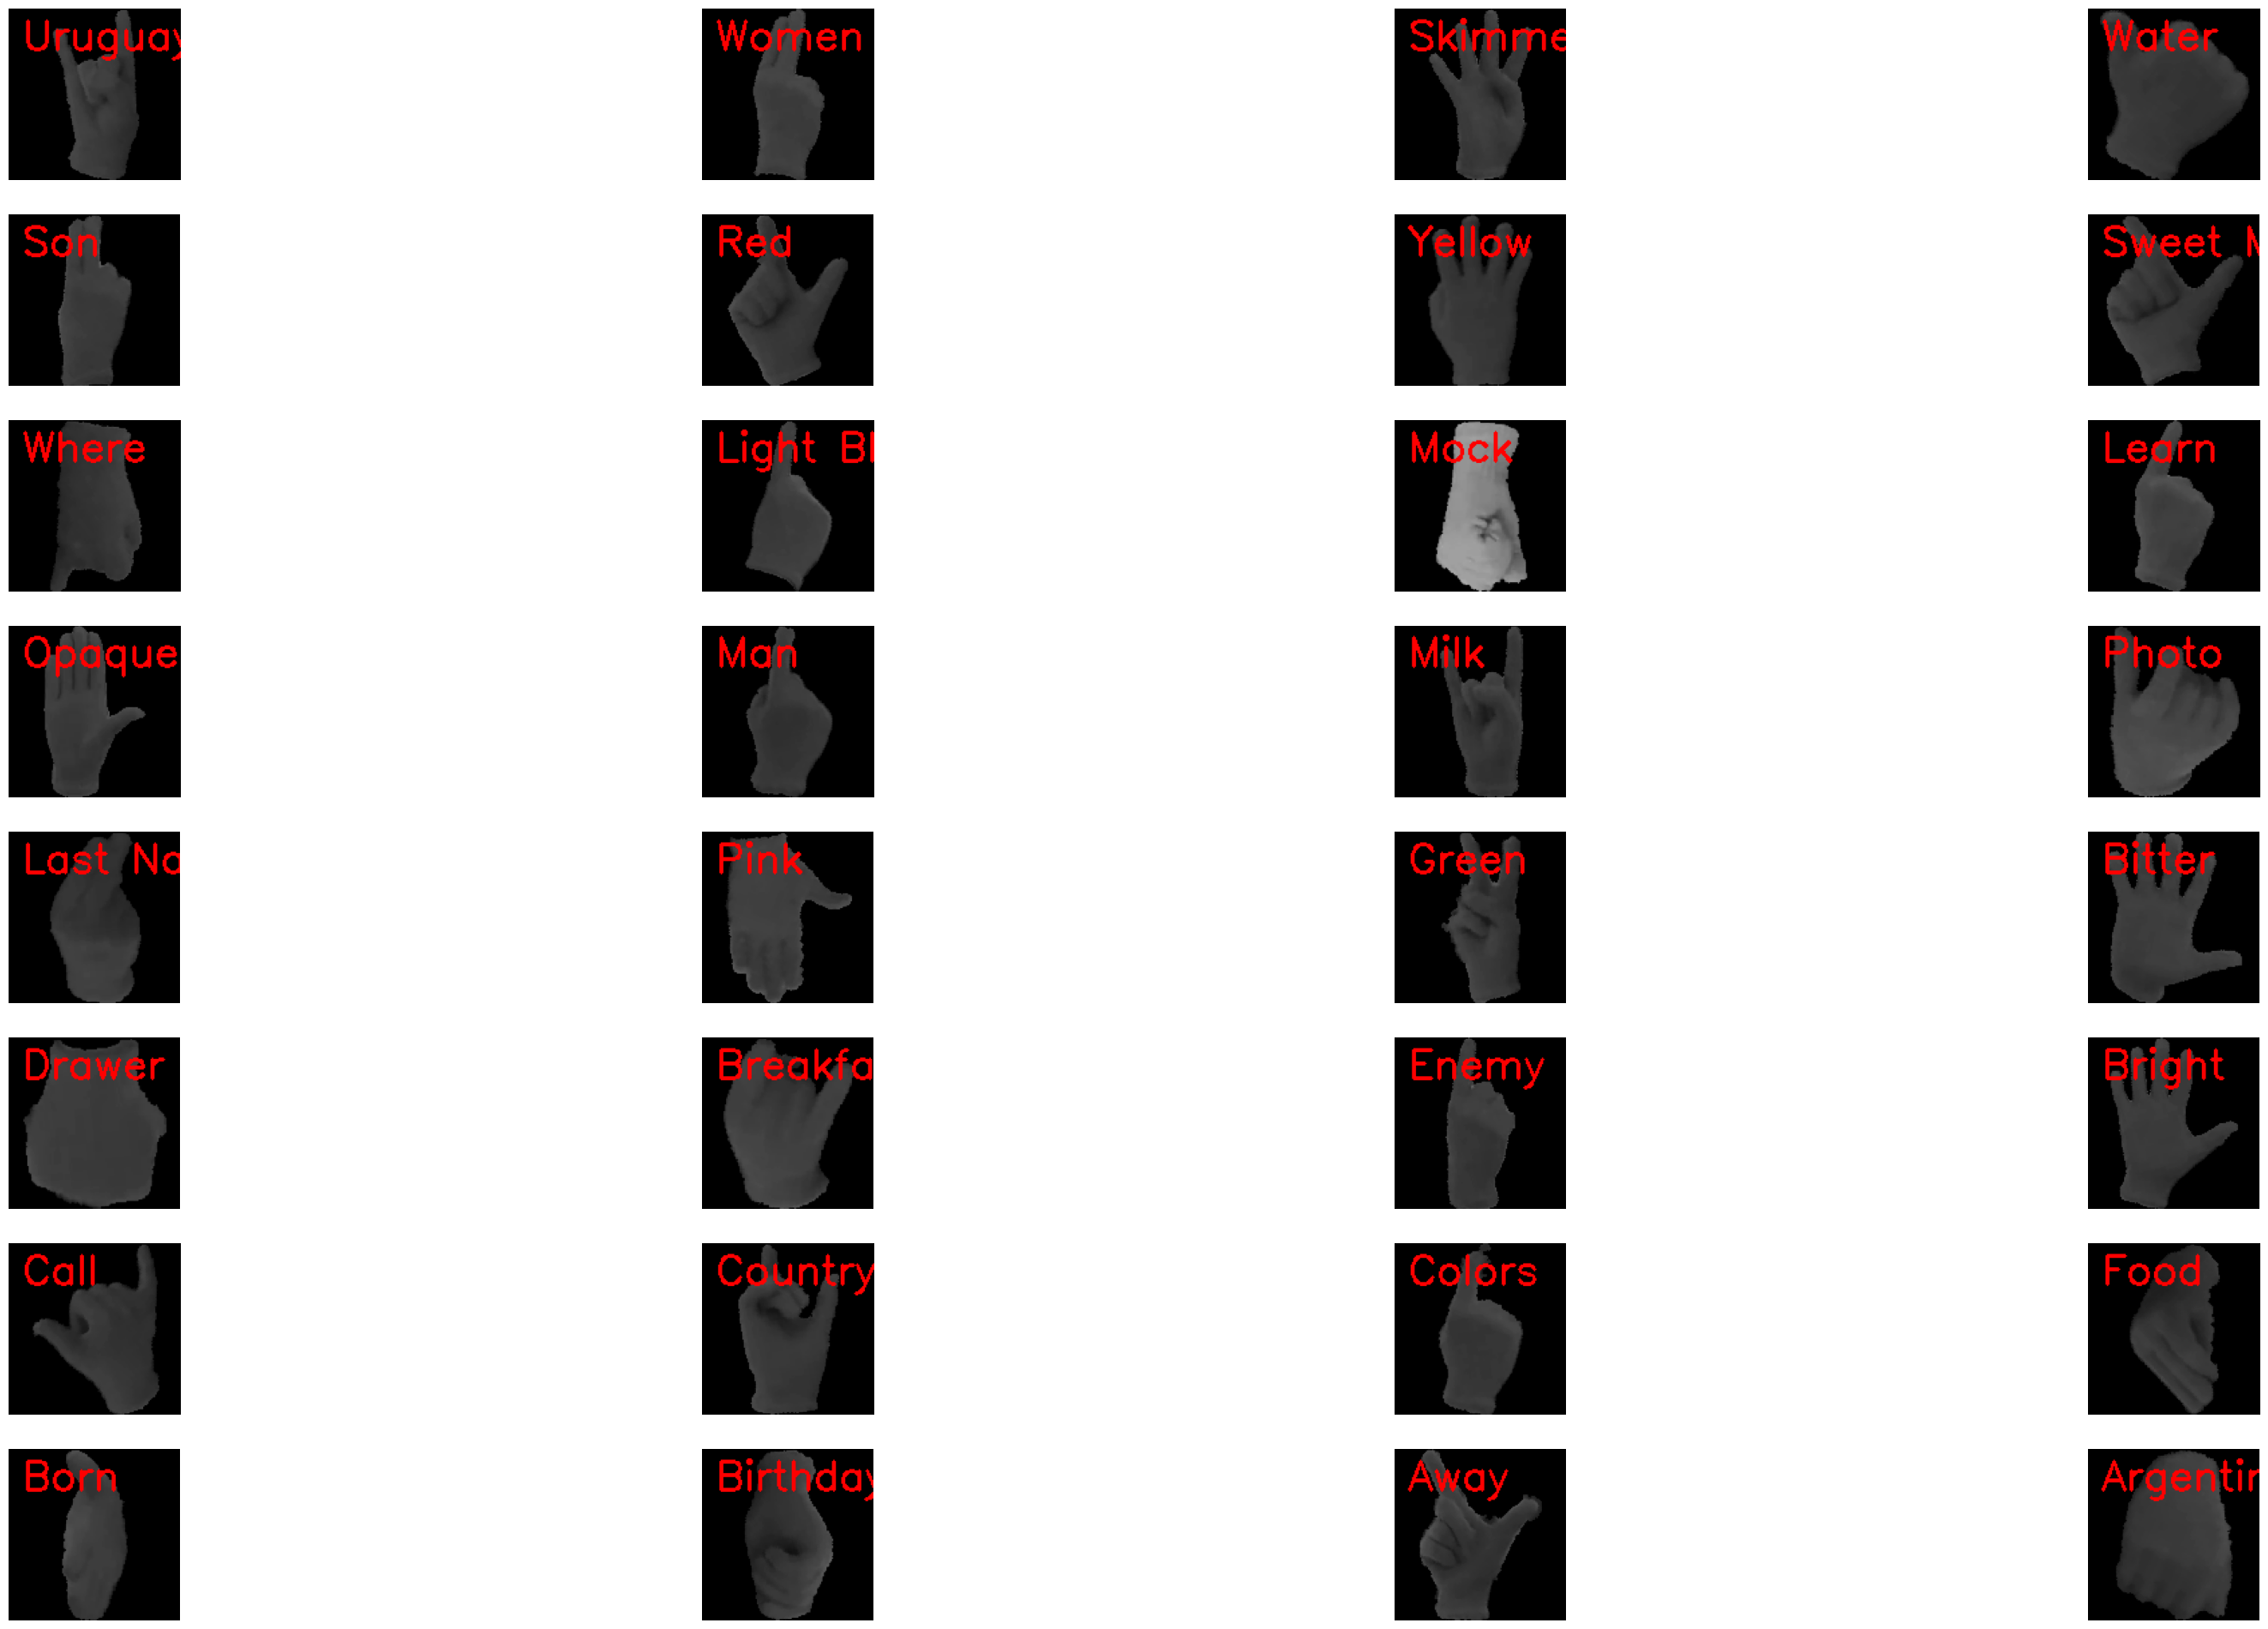

In [ ]:
## DISPLAYING THE FIRST FRAME OF A RANDOM VIDEO FOR EACH OF THE 3 CATEGORIES

# Define the structure that represents the single frame
plt.figure(figsize = (40, 40))

# Define directory to extract category names
all_classes_names = os.listdir('/content/drive/MyDrive/Dataset/Labels/')

# At this point we can define a *for* loop to iterate over the length of the category list
# and thus define the *counter* value to extract each single category
for counter in range(len(all_classes_names)):

     # Extract a category based on the *counter*
     selected_class_Name = all_classes_names[counter]

     # Subsequently the list of all the videos of the previously extracted category is extracted
     video_files_names_list = os.listdir(f'/content/drive/MyDrive/Dataset/Labels/{selected_class_Name}')

     # At this point you can decide to randomly choose a video among all the existing ones
     selected_video_file_name = random.choice(video_files_names_list)

     # A function of the cv2 library is used, ie VideoCapture, which allows you to define an element for reading videos
     video_reader = cv2.VideoCapture(f'/content/drive/MyDrive/Dataset/Labels/{selected_class_Name}/{selected_video_file_name}')

     # You can then "read" the video and extract only the first frame in this case
     _, bgr_frame = video_reader.read()

     # Once the frame is extracted, the VideoCapture must be released in order to use it with other videos
     video_reader.release()

     # Next you need to convert the frame from BGR to RGB format to get correct color display
     rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

     # Fundamental step: writing labels on each image to identify the action performed in the video
     cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

     # Finally the display of the different images
     counter+=1
     plt.subplot(13, 4, counter);plt.imshow(rgb_frame);plt.axis('off')

# 2. Data preprocessing

In order to work with this type of data it is necessary to carry out some preliminary cleaning, correction and transformation operations. in fact, it is necessary to normalize the frames extracted from each video, above all to reduce the computational cost.

In [ ]:
## INITIALIZATION OF CONSTANTS FOR DIMENSIONALITY AND NUMBER OF FRAMES FOR VIDEOS

# First define the new size to which to resize the frames
# It was decided to use this to keep the rectangular shape of the videos and because larger sizes didn't favor using too much templates
# complex due to high RAM usage
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 96

# The number of frames to be extracted from each video is also defined, the greater the number of frames the more precise the model will be,
# but at the same time it increases the computational cost
SEQUENCE_LENGTH = 10

All the parameters just defined can be increased to obtain better results, at the same time a deadlock situation will be reached in which no performance improvement can be obtained but only a computationally expensive process.

In [ ]:
## DEFINITION OF PATH TO DATASET AND LIST WITH CATEGORIES NAMES

# Directory to data
DATASET_DIR = "/content/drive/MyDrive/Dataset/Labels/"

# List with category names
all_classes_names = os.listdir('/content/drive/MyDrive/Dataset/Labels/')

CLASSES_LIST = all_classes_names

The next step is to create a function that allows you to extract the frames from the videos, resize them using the parameters just defined and normalize them in a range (0,1) by dividing each single pixel by the value 255.

It is a function that presents as input argument the directory of the dataset with the videos, and as output a list containing the resized and normalized frames. It is emphasized that the function just mentioned will be used within the next function.

In [ ]:
def frames_extraction(video_path):

     # Initialize an empty list that will contain the frames
     frames_list = []

     # Resumes the VideoCapture function previously used to "read" videos
     video_reader = cv2.VideoCapture(video_path)

     # At this point you need to extract the total number of frames for video, this is why
     # frames must be extracted for the full length of the videos and not just at the beginning
     video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

     # This splits the video into equal frame intervals
     skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

     # Iterate a for loop that will choose 20 frames for video, resize and normalize them individually,
     # to then add them to the previously initialized list
     for frame_counter in range(SEQUENCE_LENGTH):

         # In this way the 20 frames on the entire video are selected evenly
         video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

         # The command is used to read the videos
         # The *success* element is also defined because the read element also outputs a boolean value
         # which gives the outcome of the procedure
         success, frame = video_reader.read()

         # In fact, this way it checks if the reading was successful
         if not success:
             break

         # Once the frames are extracted, you need to resize them to the size you choose yourself
         resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

         # Finally we normalize each single frame by dividing it by 255 so that the value of each single pixel is between 0 and 1
         normalized_frame = resized_frame / 255

         # After having done all the necessary procedures to obtain elements that are easier to read, analyze and understand,
         # it is possible to add them to the list of frames which will form the main element of the starting dataset
         frames_list.append(normalized_frame)

     # As mentioned above, after each read it is necessary to release the VideoCapture element so that it can be used on other videos
     video_reader.release()

     # Being a function it is necessary to supply a return command regarding the list of frames
     return frames_list

### **<font style="color:rgb(134,19,348)">Dataset Creation Function</font>**


The create_dataset() function is implemented which will iterate through all the classes specified in the CLASSES_LIST constant and will call the frame_extraction() function on each video file of the selected classes to finally return the frames (features), the class index (labels) and the video file path (video_files_paths).

In [ ]:
def create_dataset():

    # I declare the lists in which I will store the features, labels and filepaths
    features = []
    labels = []
    video_files_paths = []
    n=0
    # Iteration through all the classes of the CLASSES_LIST variable
    for class_index, class_name in enumerate(CLASSES_LIST):
        if(n<10):
            print(n)
            print(f'Extracting Data of Class: {class_name}')
            # List of videos in specific class
            files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
            # Iteration through the class file list
            for file_name in files_list:
                # Extract the video path
                video_file_path = os.path.join(DATASET_DIR, class_name, file_name)
                # I extract the frames of each video with the function created above
                frames = frames_extraction(video_file_path)
                # Verify that the extracted frames of each video match the SEQUENCE_LENGHT variable
                if len(frames) == SEQUENCE_LENGTH:
        # Add the extracted elements to the respective lists
                    features.append(frames)
                    labels.append(class_index)
                    video_files_paths.append(video_file_path)
            n=n+1
    # Return frames, classes, and filepaths
    return features, labels, video_files_paths

The function created above is applied by saving the elements by working with the CPU, which is much more efficient in this type of operation.

In [ ]:
with tf.device('CPU:0'):
  features, labels, video_files_paths = create_dataset()

0
Extracting Data of Class: Uruguay
1
Extracting Data of Class: Women
2
Extracting Data of Class: Skimmer
3
Extracting Data of Class: Water
4
Extracting Data of Class: Son
5
Extracting Data of Class: Red
6
Extracting Data of Class: Yellow
7
Extracting Data of Class: Sweet Milk
8
Extracting Data of Class: Where
9
Extracting Data of Class: Light Blue


After having created the elements of interest, they are saved in the GPU, given that it is the most performing in training the various models.

In [ ]:
with tf.device('GPU:0'):
  features = features*1
  labels = labels*1
  video_files_paths = video_files_paths*1

Once the function has been implemented and applied, it is necessary to transform the features element from a list into an array with dimensionality (video number, frame number, dimensions).

In [ ]:
features = np.asarray(features)

It also shows the dimensionality of the created features element.

In [ ]:
features.shape, features.size

((500, 10, 96, 64, 3), 92160000)

Same procedure for labels, i.e. the labels saved in a vector of length equal to the number of videos present.

In [ ]:
labels = np.array(labels)

Finally, we need to create an array of the labels via one_hot_encoded conversion.

In [ ]:
one_hot_encoded_labels = to_categorical(labels)

#3. Division of data into Training and Validation Set

Once the actual dataset has been created from which you can train the different models to be used for video classification with your own labels, you need to split the data into Training and Validation Sets. They respectively represent the portion of data to improve performance of the model and to evaluate the performance on new data.

It was also decided to insert as subdivision parameters both the *shuffle* option, which allows to reduce the bias, and the *stratify* option, which allows to maintain the same distribution of the categories in the two new datasets. Finally, the same seed defined previously was maintained and a percentage of about 25% of the starting set was decided as the size of the validation set.

In [ ]:
## DIVISION OF THE SET OF FEATURES

# To verify the stratification, the following function comes using the non-one-hot-encoded label vector in the way that it can be interpreted.

features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size = 0.25, shuffle = True,
                                                                            random_state = seed_constant, stratify = labels)

In this way, the correct homogeneity of the classes in the two datasets is verified

In [ ]:
import collections
collections.Counter(labels_train)

Counter({3: 37, 2: 37, 5: 38, 4: 37, 8: 38, 9: 37, 7: 38, 1: 38, 6: 37, 0: 38})

In [ ]:
collections.Counter(labels_test)

Counter({9: 13, 3: 13, 0: 12, 1: 12, 2: 13, 8: 12, 6: 13, 5: 12, 4: 13, 7: 12})

We verify that the frequencies are very similar, therefore we are satisfied with the division and we can apply it using the matrix of labels previously created.

In [ ]:
## FEATURE SET DIVISION

# Keep 75% of the observations for the training set and 25% for the validation set

features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels,
                                                                             test_size = 0.25, shuffle = True,
                                                                             random_state = seed_constant,
                                                                             stratify = labels)

#4. Implementation of classification models: LRCN approach

For this particular type of data, it was decided to try a solution that combines two different types of neural networks: Convolutional Neural Network (CNN) and Long short-Term Memory (LSTM). In the union of these two strategies the CNN layers are used to extract the spatial features from the frames, and each of them is subsequently sent to the LSTM layer for time sequence modeling. A Long-Term Recurrent Convolutional Network is obtained which directly learns the spatio-temporal characteristics leading to the construction of a robust model.

Another important feature of the network structure is the use of the *TimeDistributed* layer which is essential in situations of this type; in fact it allows you to apply the same layer to each video frame independently. Basically it adds the parameter *number of frames* to the layer input, ie it replaces the input of a single frame with the input of the entire video.

Paper: https://arxiv.org/abs/1411.4389?source=post_page

### Template structure

The first model we decided to define is relatively simple: it features a *Conv2D* layer with *TimeDistributed* and 64 4x4 size filters. Subsequently a *GlobalMaxPooling2D* layer is inserted which allows to create the input suitable for the last layer of *LSTM*. Finally, there is a *Dense* layer with a softmax activation function which, through a probability between 0 and 1, provides us with the prediction of the action performed within the video.

In [ ]:
def create_LRCN_model_basic():

     # Initialize a sequential model
     model = Sequential()

     # Conv2D first layer with 64 4x4 size filters and 'relu' trigger function
     model.add(TimeDistributed(Conv2D(64, (8, 8), padding='same',activation = 'relu'),
                               input_shape = (SEQUENCE_LENGTH, IMAGE_WIDTH, IMAGE_HEIGHT,3)))

     # GlobalMaxPooling2D layer
     model.add(TimeDistributed(GlobalMaxPooling2D()))

     # LSTM layer with 64 neurons and 'tanh' activation function
     model.add(LSTM(64, activation = 'tanh'))

     # Finally Dense layer with 'softmax' activation function to reduce the output to the number of categories equal to 19
     model.add(Dense(10, activation = 'softmax'))

     model.summary()

     return model

In [ ]:
# Create the model by calling the previous function

LRCN_model_basic = create_LRCN_model_basic()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 10, 96, 64, 64)   12352     
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 10, 64)           0         
 tributed)                                                       
                                                                 
 lstm (LSTM)                 (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 10)                650       
                                                                 
Total params: 46,026
Trainable params: 46,026
Non-trainable params: 0
_________________________________________________________________


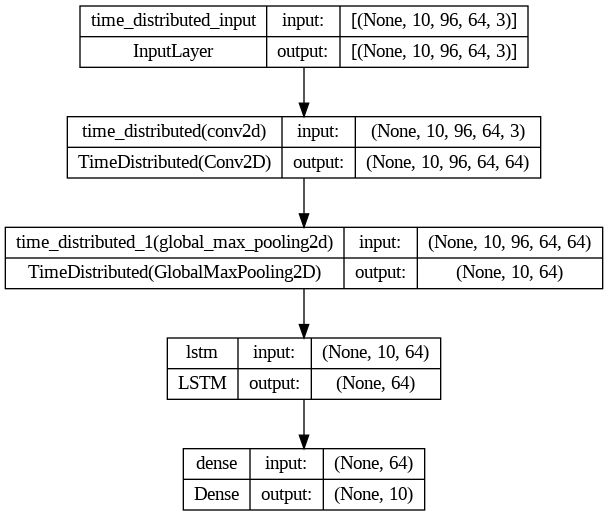

In [ ]:


plot_model(LRCN_model_basic, to_file = 'LRCN_basic_model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [ ]:
## MODEL PARAMETERS AND FITTINGS

# An Early Stopping parameter is created, stopping the algorithm when the loss on the validation does not decrease after more than 15 epochs
early_stopping_callback = EarlyStopping(monitor = 'loss', patience = 15, mode = 'min', restore_best_weights = True)

# The compile command is used to define the loss metric, the metrics to optimize and which method to apply; in
# this case we have chosen to use "Adam", i.e. the stochastic gradient descent
LRCN_model_basic.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Once all the parameters of interest have been defined, it is possible to start training the model on the training set and directly evaluate the
# performance on validation after each epoch. Also *shuffle* is inserted to further reduce the bias during
# the training
LRCN_model_basic_training_history = LRCN_model_basic.fit(x = features_train, y = labels_train, epochs = 30, batch_size =64,
                                                          shuffle = True, callbacks = [early_stopping_callback],
                                                         validation_data = (features_test, labels_test))

Epoch 1/30
6/6 [==============================] - 18s 767ms/step - loss: 2.3079 - accuracy: 0.1067 - val_loss: 2.2893 - val_accuracy: 0.0960
Epoch 2/30
6/6 [==============================] - 1s 186ms/step - loss: 2.2865 - accuracy: 0.0800 - val_loss: 2.2726 - val_accuracy: 0.2400
Epoch 3/30
6/6 [==============================] - 1s 188ms/step - loss: 2.2641 - accuracy: 0.3200 - val_loss: 2.2451 - val_accuracy: 0.2880
Epoch 4/30
6/6 [==============================] - 1s 190ms/step - loss: 2.2292 - accuracy: 0.3707 - val_loss: 2.1881 - val_accuracy: 0.5680
Epoch 5/30
6/6 [==============================] - 1s 190ms/step - loss: 2.1532 - accuracy: 0.4960 - val_loss: 2.0552 - val_accuracy: 0.5680
Epoch 6/30
6/6 [==============================] - 1s 189ms/step - loss: 1.9401 - accuracy: 0.4853 - val_loss: 1.7039 - val_accuracy: 0.6480
Epoch 7/30
6/6 [==============================] - 1s 189ms/step - loss: 1.5041 - accuracy: 0.5653 - val_loss: 1.2631 - val_accuracy: 0.5840
Epoch 8/30
6/6 [===

In [ ]:
# Retrieve the performance of the best estimated model

model_evaluation_history = LRCN_model_basic.evaluate(features_test, labels_test)

4/4 [==============================] - 1s 136ms/step - loss: 0.1986 - accuracy: 0.9200


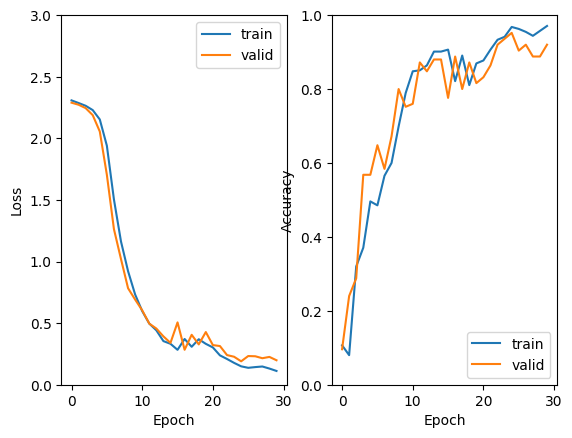

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(LRCN_model_basic_training_history.history['loss'])
plt.plot(LRCN_model_basic_training_history.history['val_loss'])
plt.ylim([0, 3.0])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid'])

plt.subplot(1, 2, 2)
plt.plot(LRCN_model_basic_training_history.history['accuracy'])
plt.plot(LRCN_model_basic_training_history.history['val_accuracy'])
plt.ylim([0, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid'])

In [ ]:

base_model = keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

model = keras.Sequential()
model.add(keras.layers.TimeDistributed(base_model))
model.add(keras.layers.GlobalAveragePooling2D())
model.add(keras.layers.LSTM(64))
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(len(labels), activation='softmax'))
# Step 6: Compile and train the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


94765736/94765736 [==============================] - 3s 0us/step


In [ ]:
model.summary

<bound method Model.summary of <keras.engine.sequential.Sequential object at 0x7f1625fd22f0>>